In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow.examples.tutorials.mnist.input_data as mnist

%matplotlib inline

In [145]:
# Get data from mnist
data = mnist.read_data_sets('/mnist_pic/')
data_train = data.train.images
label_train = data.train.labels
num_train, shape_img = data.train.images.shape
shape_img = [-1,28,28,1]

Extracting /mnist_pic/train-images-idx3-ubyte.gz
Extracting /mnist_pic/train-labels-idx1-ubyte.gz
Extracting /mnist_pic/t10k-images-idx3-ubyte.gz
Extracting /mnist_pic/t10k-labels-idx1-ubyte.gz


In [146]:
def set_input(noise_shape, image_shape):
    # image_shape = (num_exaple, height, width, depth)
    
    inputs_image = tf.placeholder(tf.float32, 
                                [None, image_shape[1], image_shape[2], image_shape[3]],
                                 name='inputs_image')
    inputs_noise = tf.placeholder(tf.float32,
                                 [None, noise_shape], name='inpute_noise')
    return inputs_image, inputs_noise

In [147]:
def generator(noise_img, num_output, alpha=0.01, share=False):
    
    with tf.variable_scope("generator", reuse=share):
        h_g1 = tf.layers.dense(noise_img, 4*4*512)
        h_g1 = tf.reshape(h_g1, [-1, 4, 4, 512])
        
        # batch normalization
        h_g1 = tf.layers.batch_normalization(h_g1, training=(not share))
        
        # Leaky Relu
        h_g1 = tf.nn.leaky_relu(h_g1, alpha=alpha)
        
        #dropout
        h_g1 = tf.layers.dropout(h_g1, rate=0.2)
        
        #4*4*512 t o 7*7*256
        h_g2 = tf.layers.conv2d_transpose(inputs=h_g1, filters=256, kernel_size=4,
                                         strides=1, padding= 'valid')
        h_g2 = tf.layers.batch_normalization(h_g2, training=(not share))
        h_g2 = tf.nn.leaky_relu(h_g2, alpha=alpha)
        h_g2 = tf.layers.dropout(h_g2, rate=0.2)
        
        # 7*7*256 to 14*14*128
        h_g3 = tf.layers.conv2d_transpose(inputs=h_g2, filters=128, kernel_size=3,
                                         strides=2, padding='same')
        h_g3 = tf.layers.batch_normalization(h_g3, training=(not share))
        h_g3 = tf.nn.leaky_relu(h_g3, alpha=alpha)
        h_g3 = tf.layers.dropout(h_g3, rate=0.2)
        
        # 14*14*128 to 28*28*1
        logits = tf.layers.conv2d_transpose(h_g3, filters=num_output, kernel_size=3, 
                                            strides=2, padding='same')
        
        outputs = tf.tanh(logits)
        
        return outputs

In [148]:
def discriminator(data_img, share=False, alpha=0.01):
    
    ### data_img: the img to be classified
    
    with tf.variable_scope("discriminator", reuse=share):
        # 28*28*1 to 14*14*128
        h_g1 = tf.layers.conv2d(data_img, filters=128, 
                                kernel_size=3, strides=2, padding='same')
        h_g1 = tf.nn.leaky_relu(h_g1, alpha=alpha)
        h_g1 = tf.layers.dropout(h_g1, rate=0.2)
        
        # 14*14*128 to 7*7*256
        h_g2 = tf.layers.conv2d(h_g1, filters=256, kernel_size=3, 
                                strides=2, padding='same')
        h_g2 = tf.layers.batch_normalization(h_g2, training=True)
        h_g2 = tf.nn.leaky_relu(h_g2, alpha=alpha)
        h_g2 = tf.layers.dropout(h_g2, rate=0.2)
        
        # 7*7*256 to 4*4*512
        h_g3 = tf.layers.conv2d(h_g2, filters=512, kernel_size=3, 
                                strides=2, padding='same')
        h_g3 = tf.layers.batch_normalization(h_g3, training=True)
        h_g3 = tf.nn.leaky_relu(h_g3, alpha=alpha)
        h_g3 = tf.layers.dropout(h_g3, rate=0.2)
        
        # 4*4*512 to 4*4*512
        # FC
        h_g_flatten = tf.reshape(h_g3, (-1, 4*4*512))
        logits = tf.layers.dense(h_g_flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

## define loss

In [149]:
def loss(data_img, noise_img, image_depth):
    
    img_generated = generator(noise_img, image_depth, share=False)
    logits_d_real, out_d_real = discriminator(data_img)
    logits_d_fake, out_d_fake = discriminator(img_generated, share=True)
    
    # calculate
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_fake,
                                                    labels=tf.ones_like(out_d_fake)*0.9))
    loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_real,
                                                    labels=tf.ones_like(out_d_real)*0.9))
    loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_fake,
                                                    labels=tf.zeros_like(out_d_fake)))
    
    loss_d = tf.add(loss_d_fake, loss_d_real)
    
    return loss_g, loss_d

In [150]:
def optimize(loss_g, loss_d, beta1=0.4, lr=0.001):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]

    # optimizer
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    with tf.variable_scope(tf.get_variable_scope(), reuse=False):
        g_optimization = tf.train.AdamOptimizer(lr, 
                                    beta1=beta1).minimize(loss_g, var_list=g_vars)
        d_optimization = tf.train.AdamOptimizer(lr,
                                    beta1=beta1).minimize(loss_d, var_list=d_vars)
        return g_optimization, d_optimization

In [173]:
def plot_images(samples):
    fig, axes = plt.subplots(nrows=1, ncols=25, sharex=True, sharey=True, figsize=(50,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [152]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]

    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(generator(inputs_noise, output_dim, share=True),
                       feed_dict={inputs_noise: examples_noise})

    
    result = np.squeeze(samples, -1)
    return result

In [153]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=0.7
# tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

Epoch 1/5.... Discriminator Loss: 1.6072.... Generator Loss: 0.7994....
Epoch 1/5.... Discriminator Loss: 1.0965.... Generator Loss: 0.9464....
Epoch 1/5.... Discriminator Loss: 1.1543.... Generator Loss: 1.8173....
Epoch 1/5.... Discriminator Loss: 1.6732.... Generator Loss: 2.0112....
Epoch 1/5.... Discriminator Loss: 1.2166.... Generator Loss: 1.2129....
Epoch 1/5.... Discriminator Loss: 1.1102.... Generator Loss: 1.2159....
Epoch 1/5.... Discriminator Loss: 1.5460.... Generator Loss: 0.5340....
Epoch 1/5.... Discriminator Loss: 0.9331.... Generator Loss: 1.6845....
Epoch 2/5.... Discriminator Loss: 1.0183.... Generator Loss: 2.0214....
Epoch 2/5.... Discriminator Loss: 1.5592.... Generator Loss: 0.5114....
Epoch 2/5.... Discriminator Loss: 1.0905.... Generator Loss: 0.8145....
Epoch 2/5.... Discriminator Loss: 1.6630.... Generator Loss: 0.4652....
Epoch 2/5.... Discriminator Loss: 1.0809.... Generator Loss: 2.0120....
Epoch 2/5.... Discriminator Loss: 1.3606.... Generator Loss: 0.6

C:\Users\TSWC\AppData\Local\conda\conda\envs\py3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 3/5.... Discriminator Loss: 1.0745.... Generator Loss: 2.5717....
Epoch 3/5.... Discriminator Loss: 1.0242.... Generator Loss: 0.9520....
Epoch 3/5.... Discriminator Loss: 1.5131.... Generator Loss: 2.9748....
Epoch 3/5.... Discriminator Loss: 0.8301.... Generator Loss: 1.3797....
Epoch 3/5.... Discriminator Loss: 0.8215.... Generator Loss: 1.7291....
Epoch 4/5.... Discriminator Loss: 0.6557.... Generator Loss: 1.6762....
Epoch 4/5.... Discriminator Loss: 1.0957.... Generator Loss: 0.7863....
Epoch 4/5.... Discriminator Loss: 0.9557.... Generator Loss: 2.6545....
Epoch 4/5.... Discriminator Loss: 0.9334.... Generator Loss: 1.0448....
Epoch 4/5.... Discriminator Loss: 0.8959.... Generator Loss: 1.0533....
Epoch 4/5.... Discriminator Loss: 0.7089.... Generator Loss: 1.7661....
Epoch 4/5.... Discriminator Loss: 1.4450.... Generator Loss: 0.6708....
Epoch 4/5.... Discriminator Loss: 1.1373.... Generator Loss: 3.3810....
Epoch 4/5.... Discriminator Loss: 1.0668.... Generator Loss: 0.8

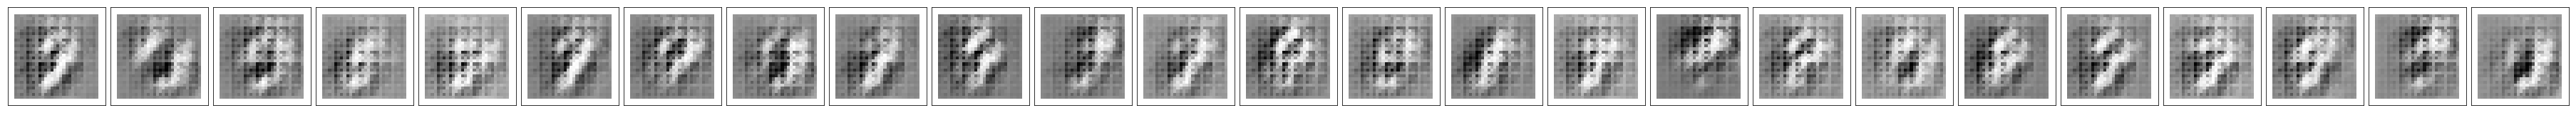

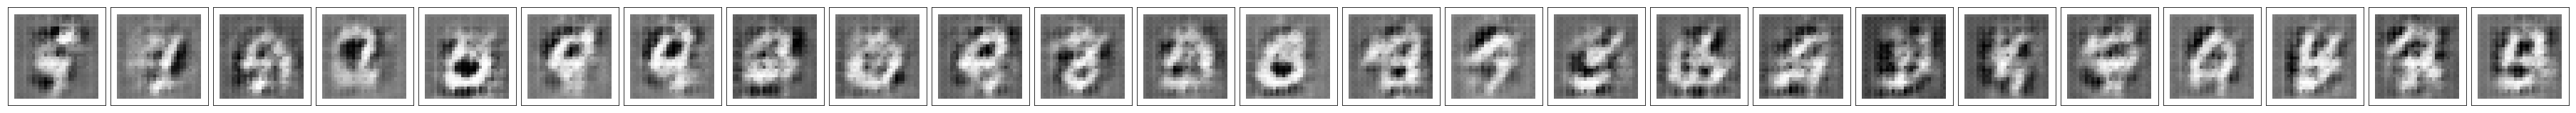

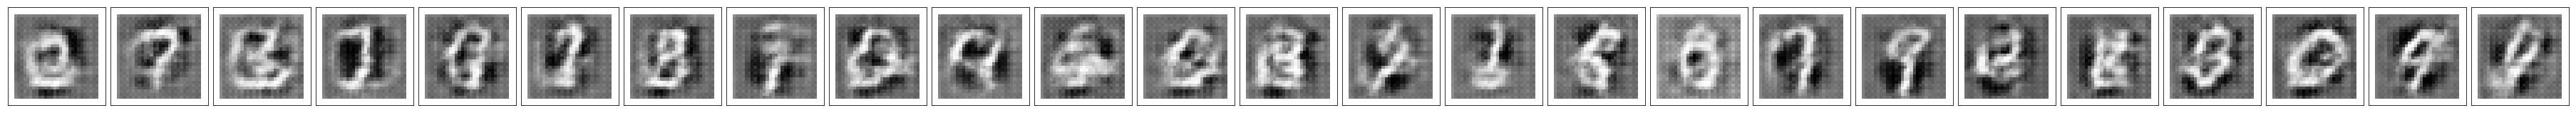

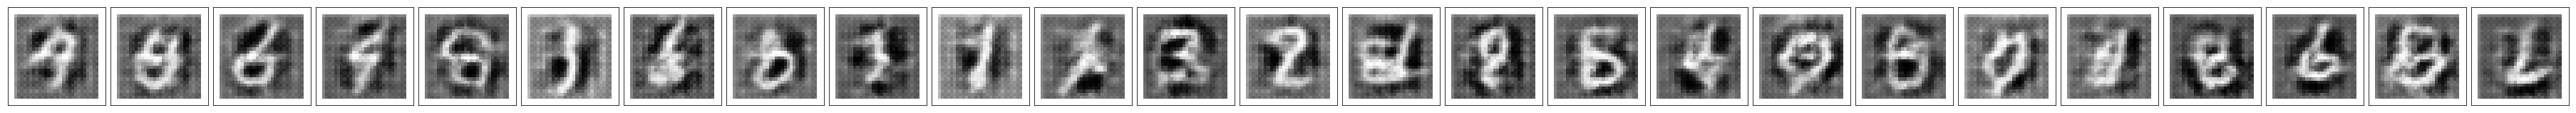

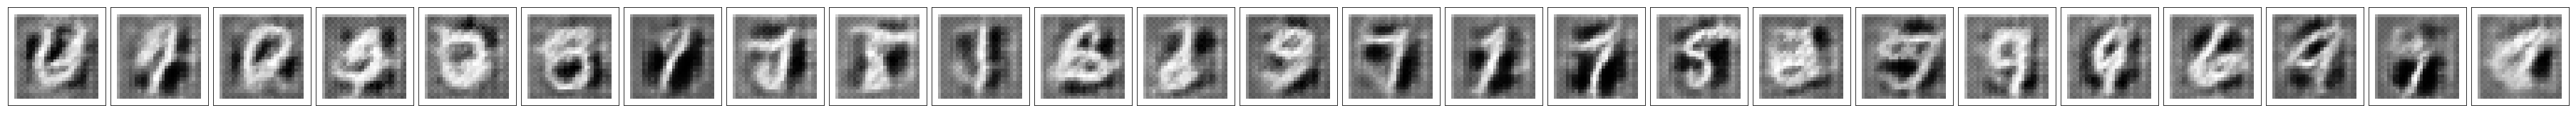

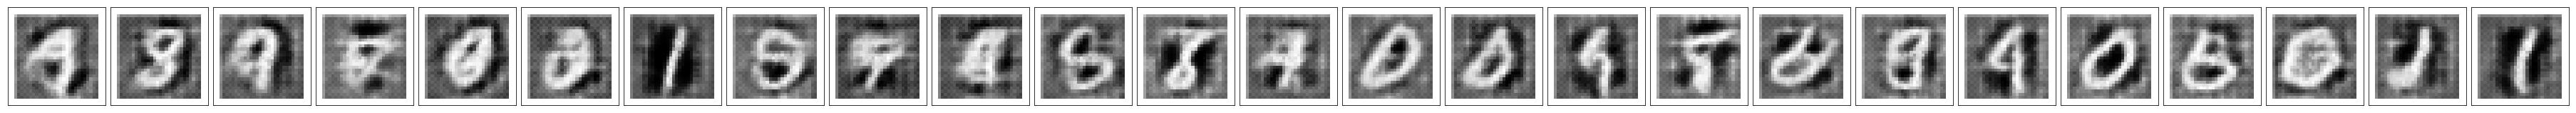

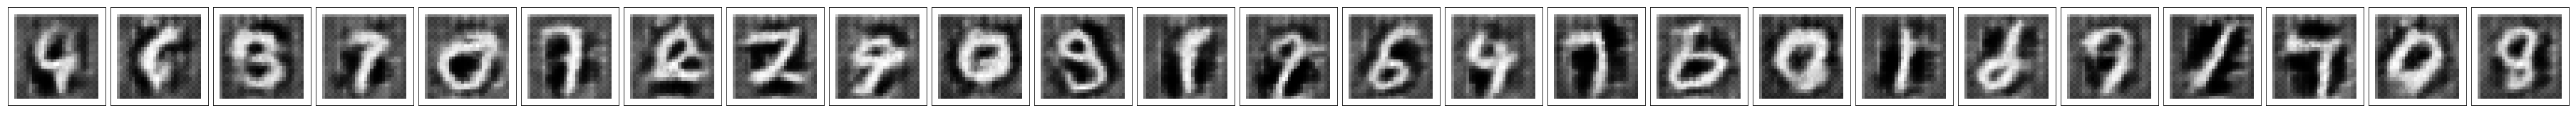

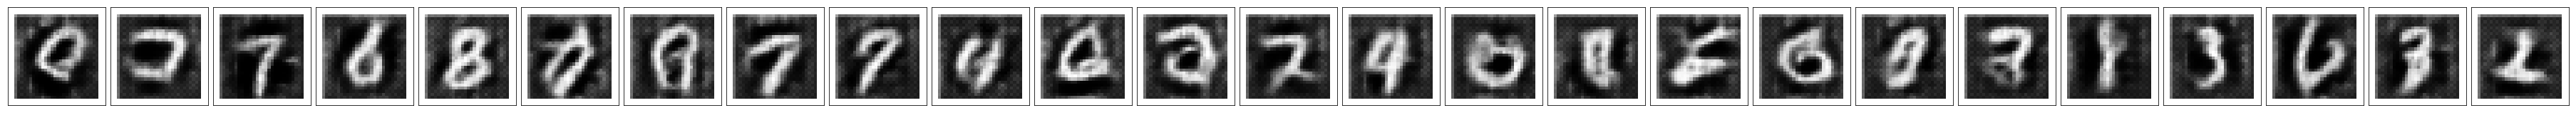

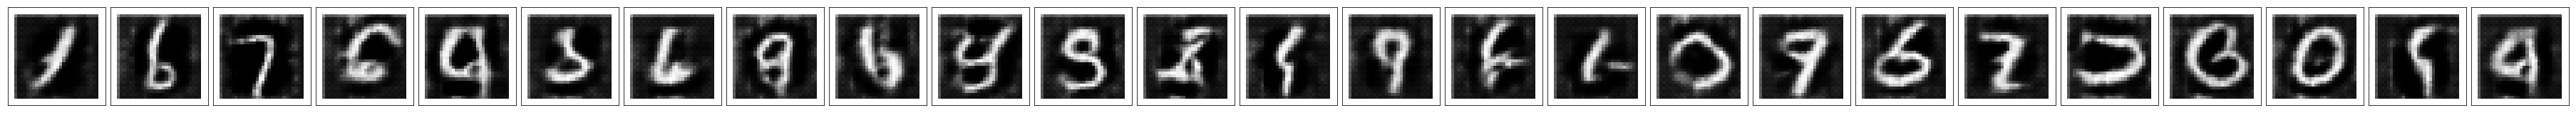

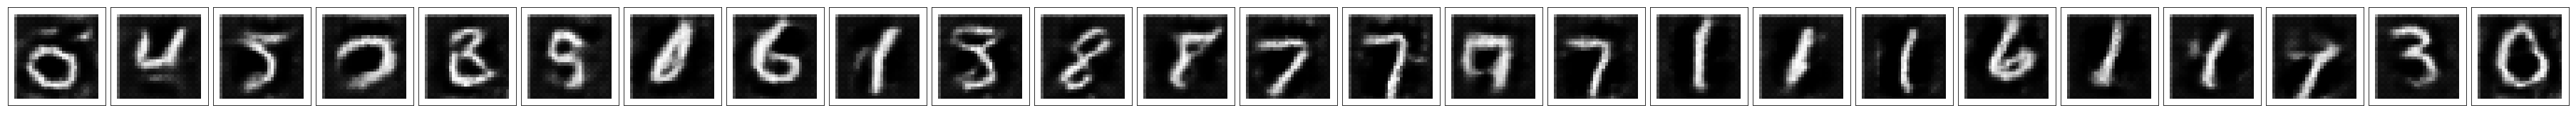

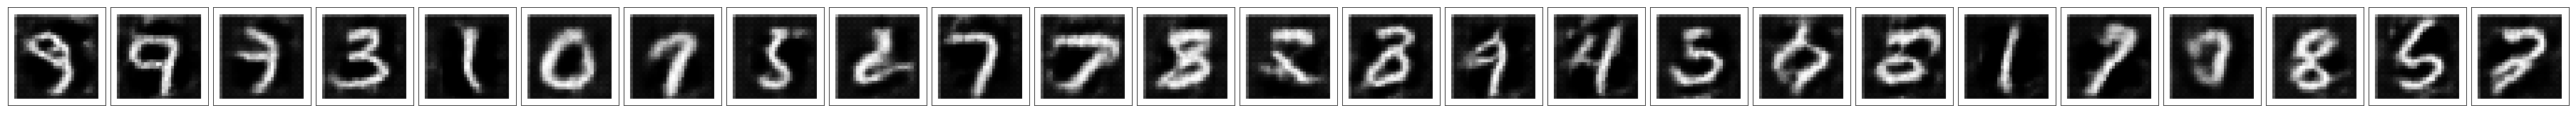

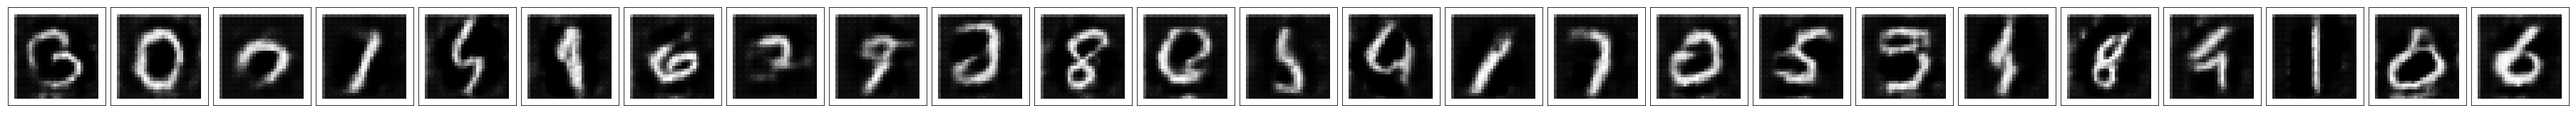

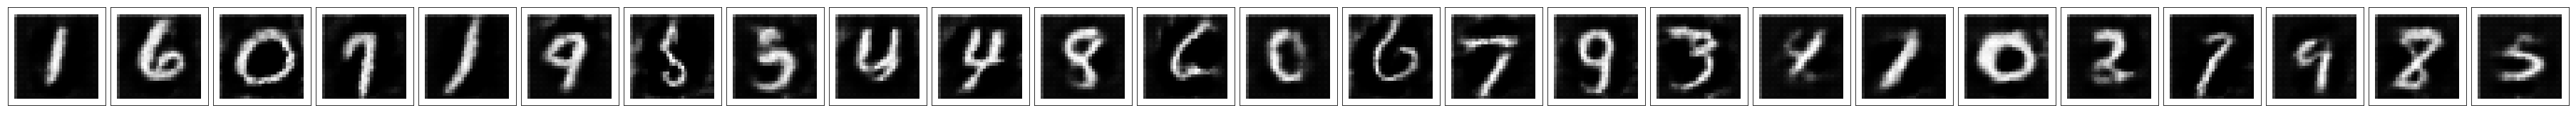

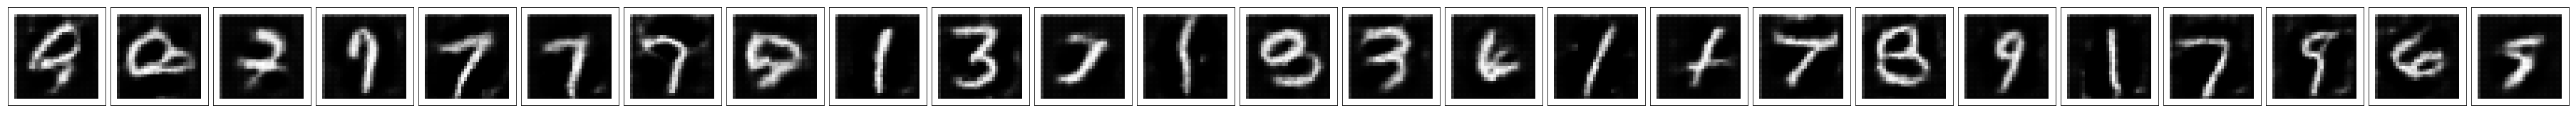

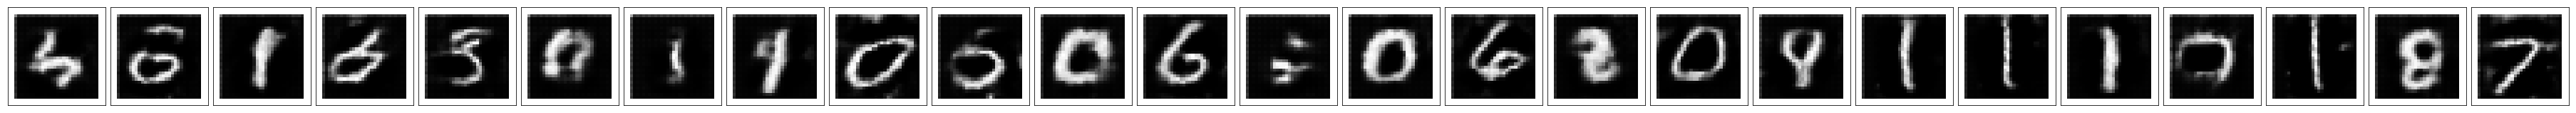

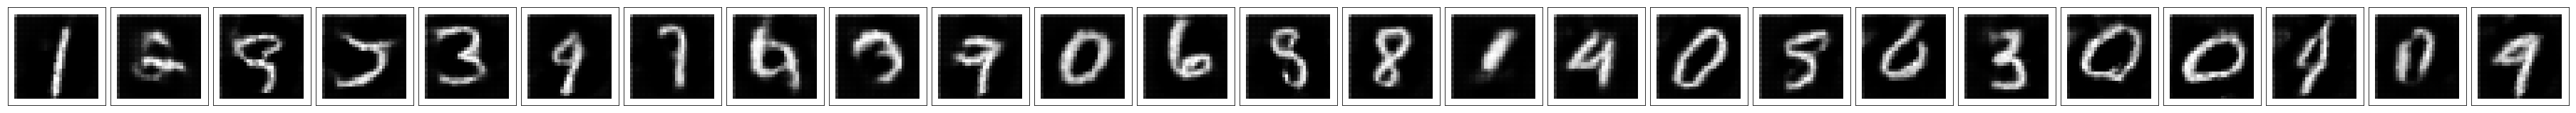

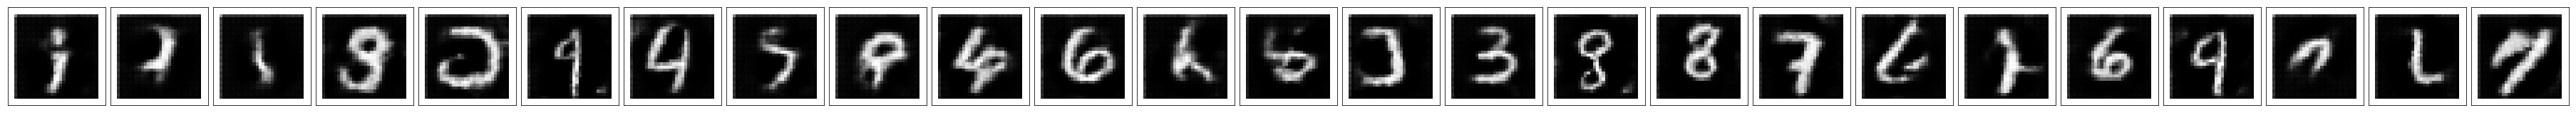

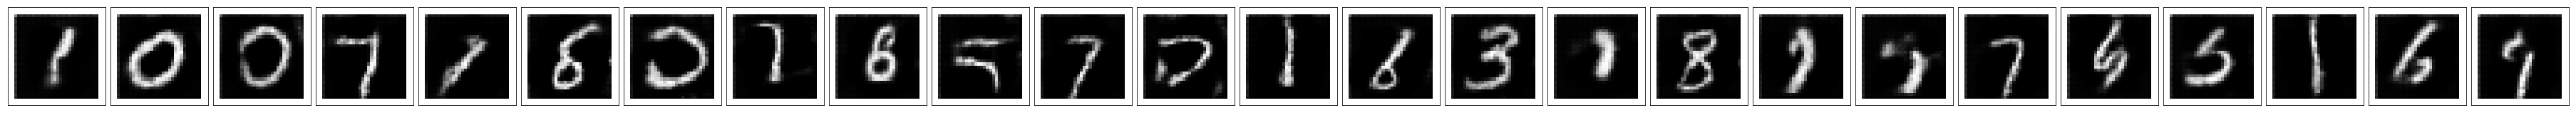

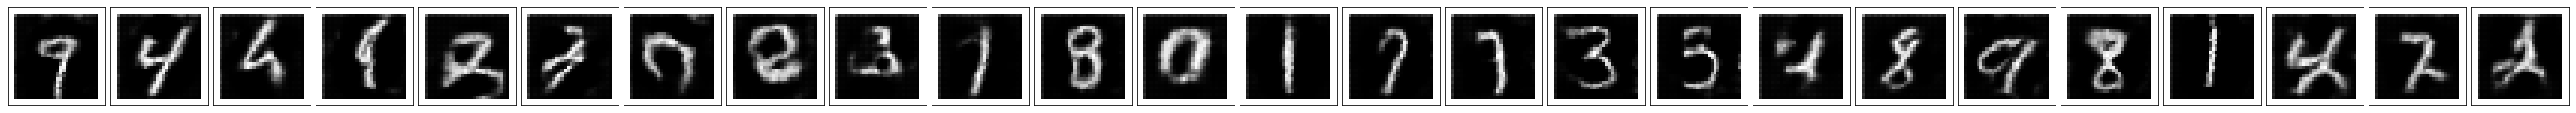

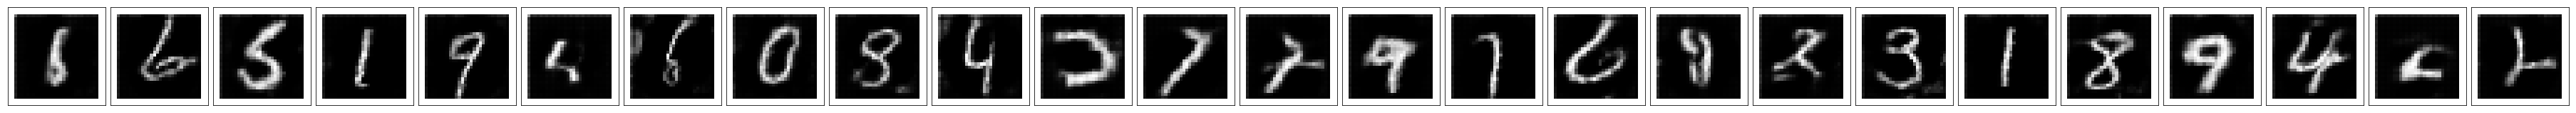

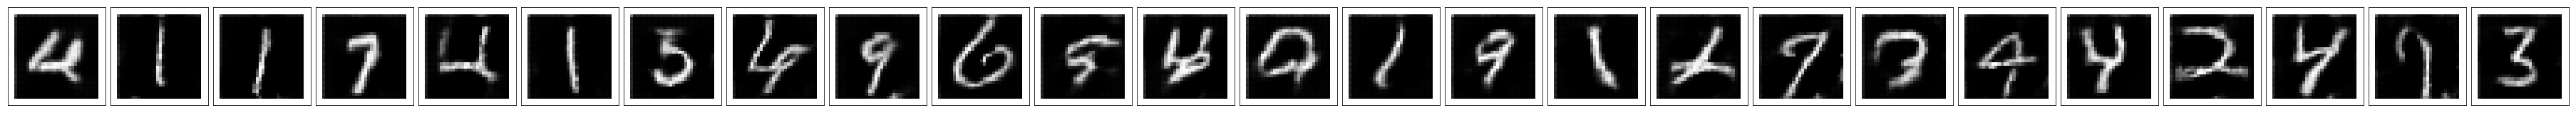

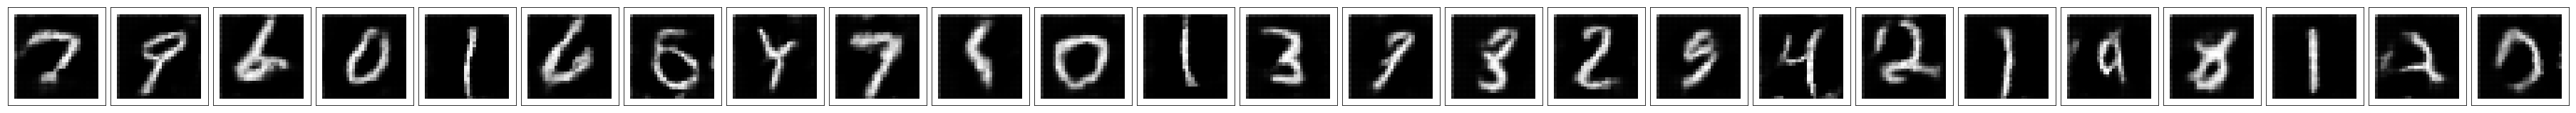

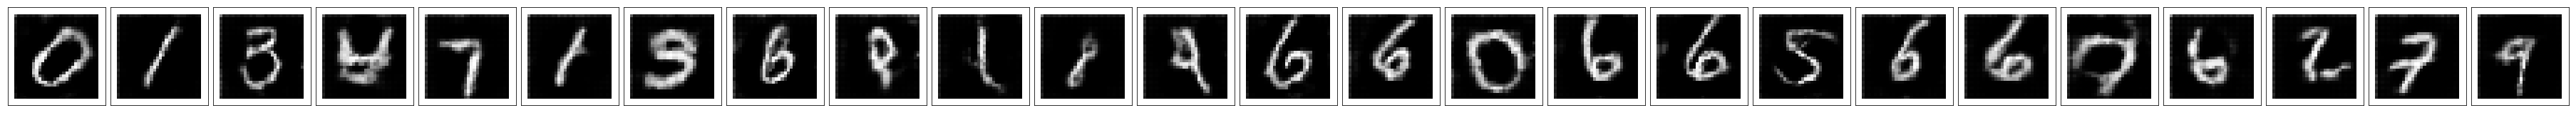

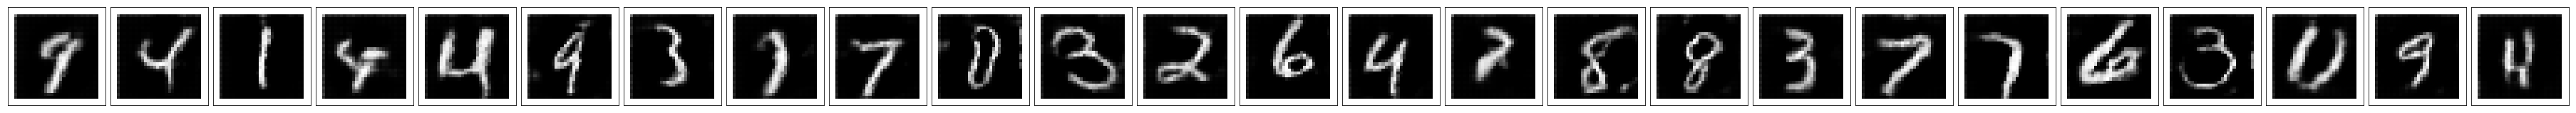

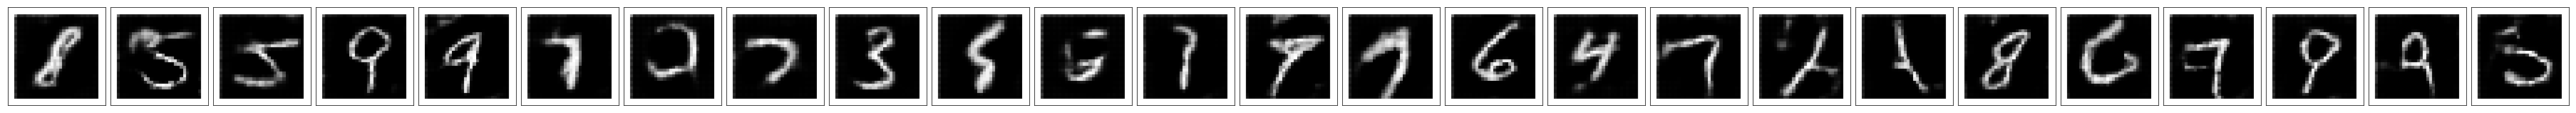

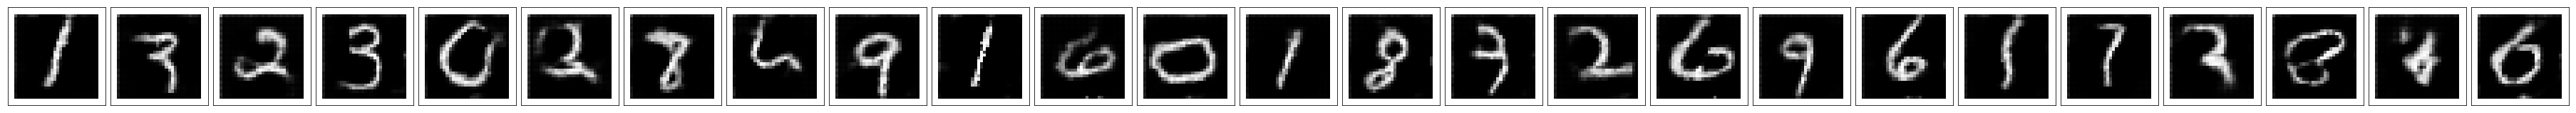

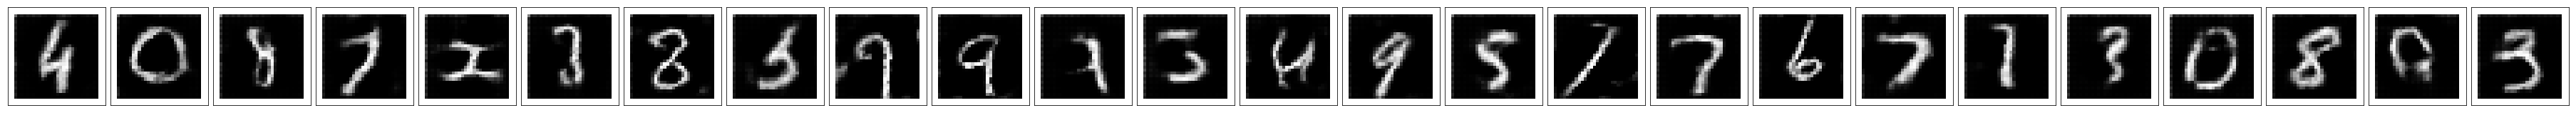

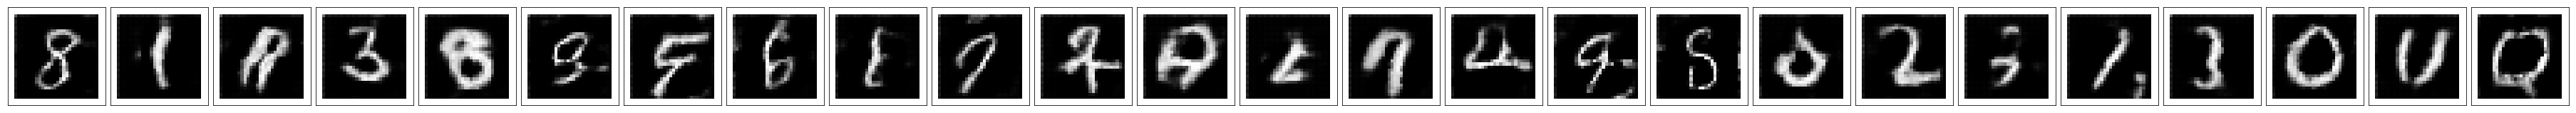

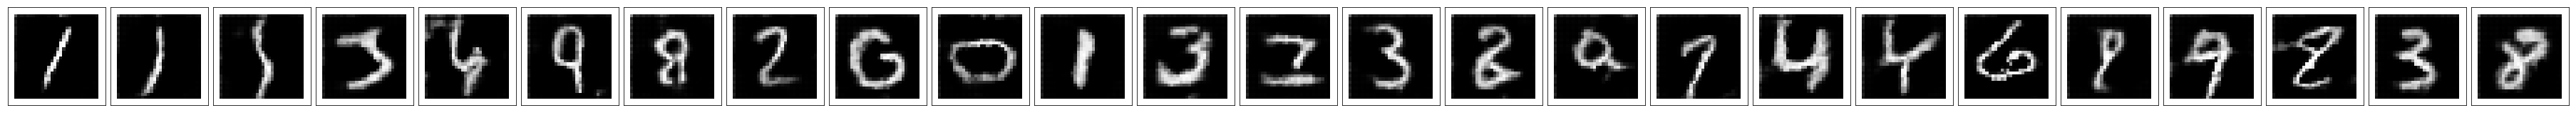

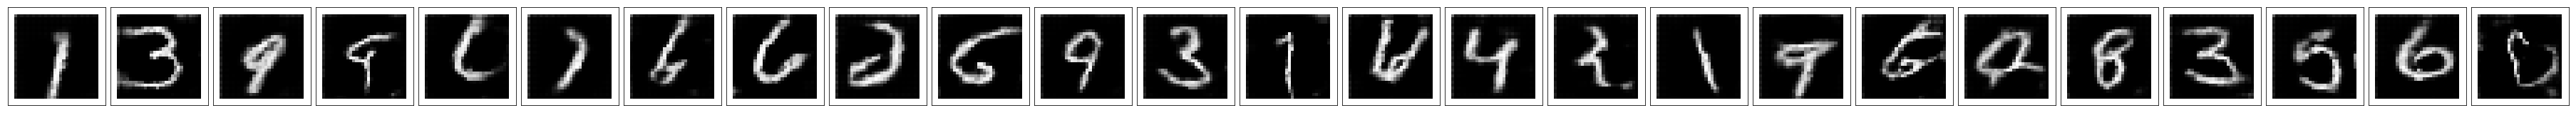

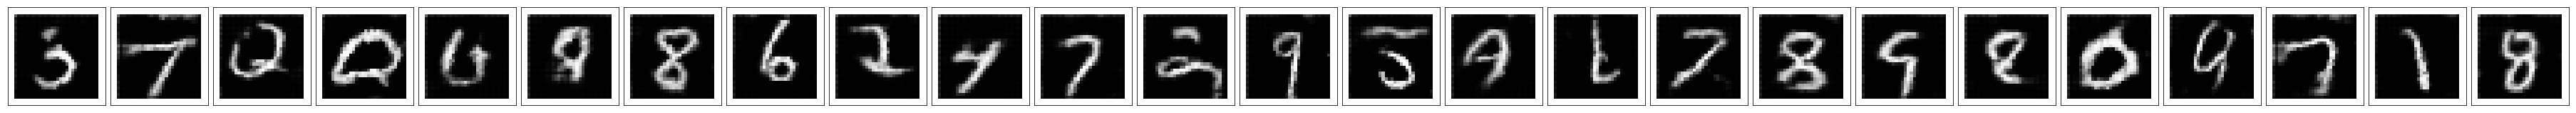

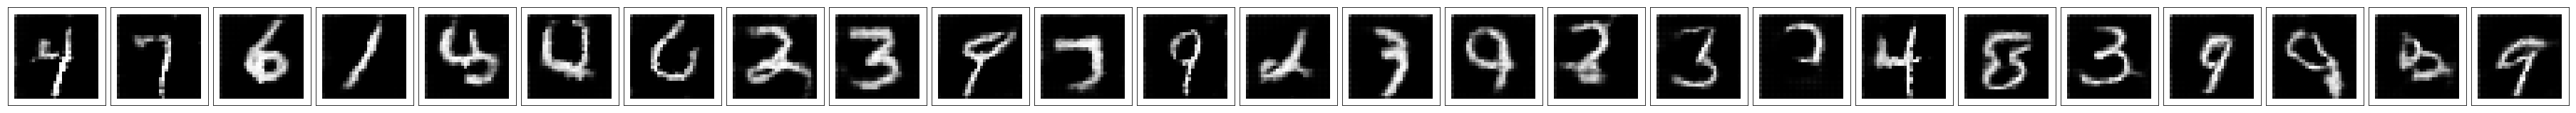

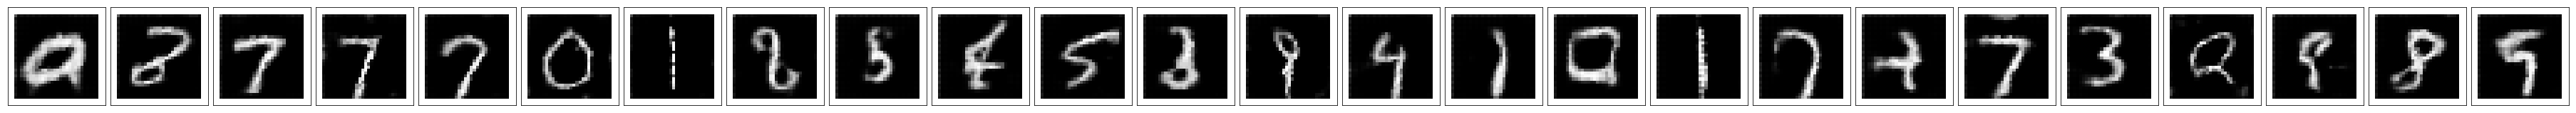

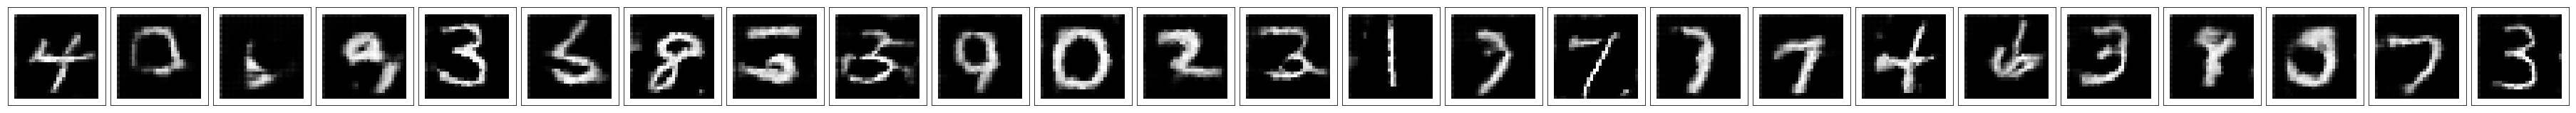

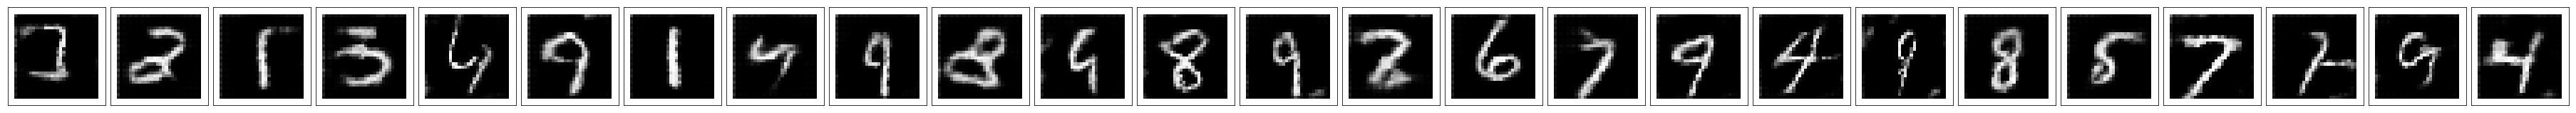

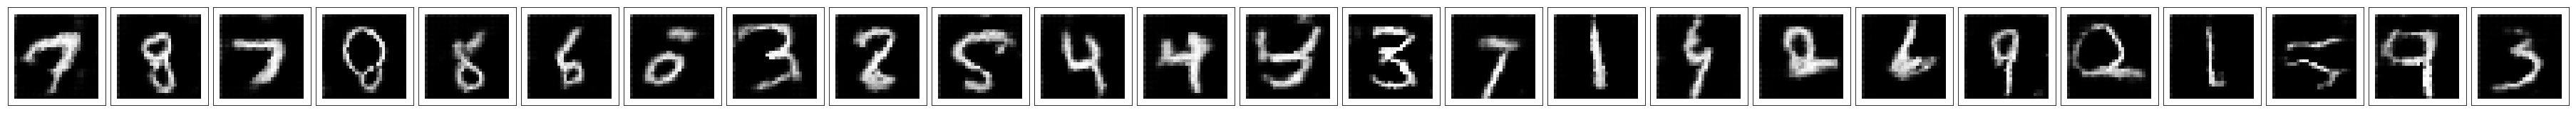

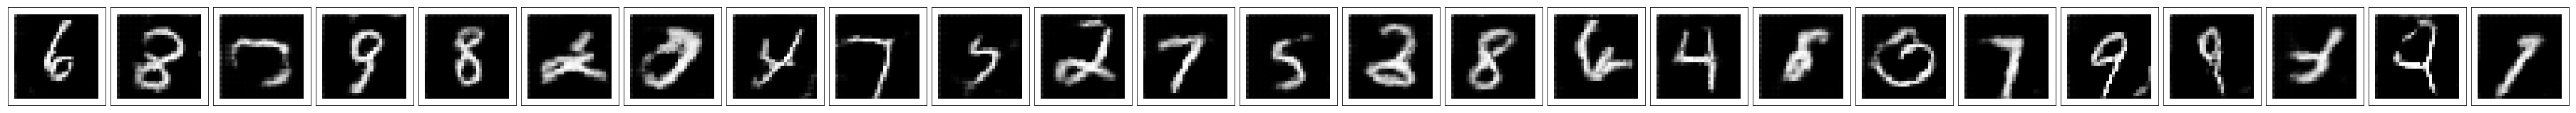

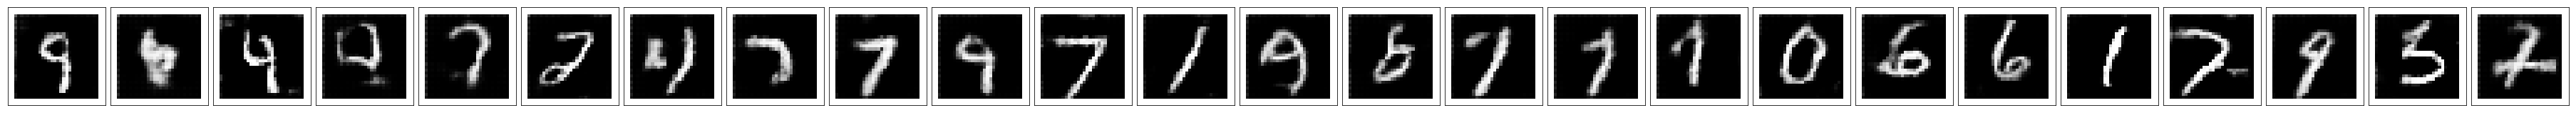

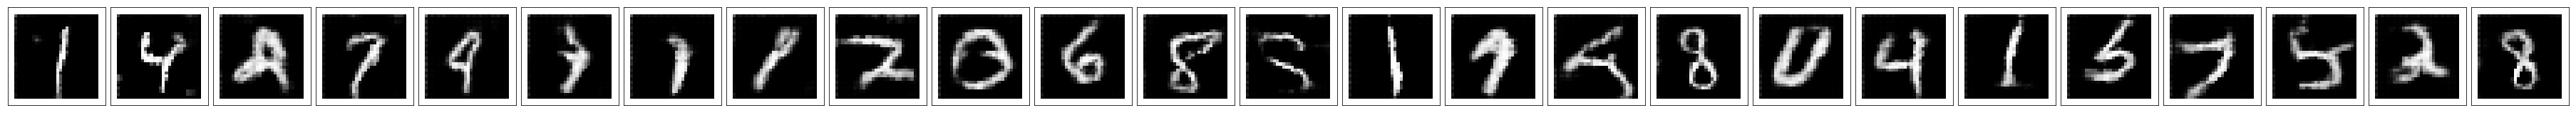

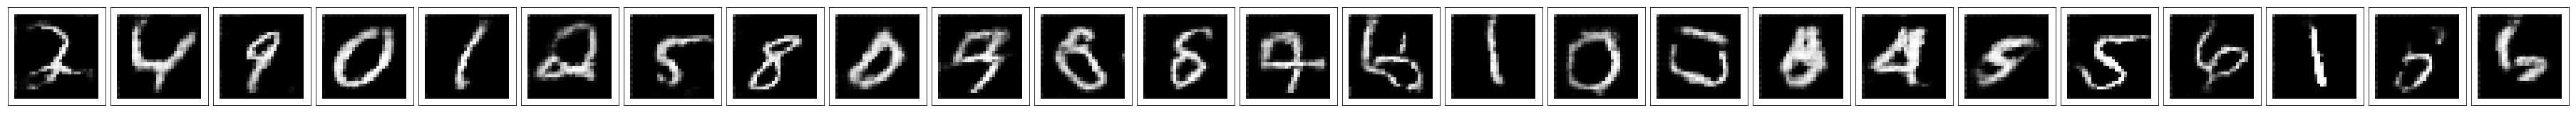

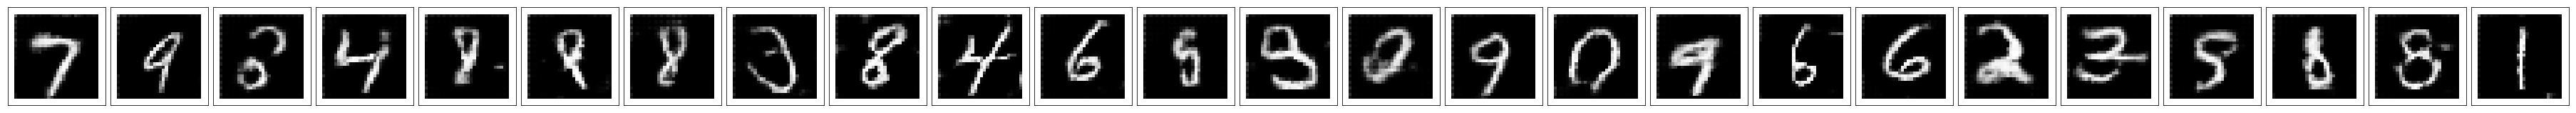

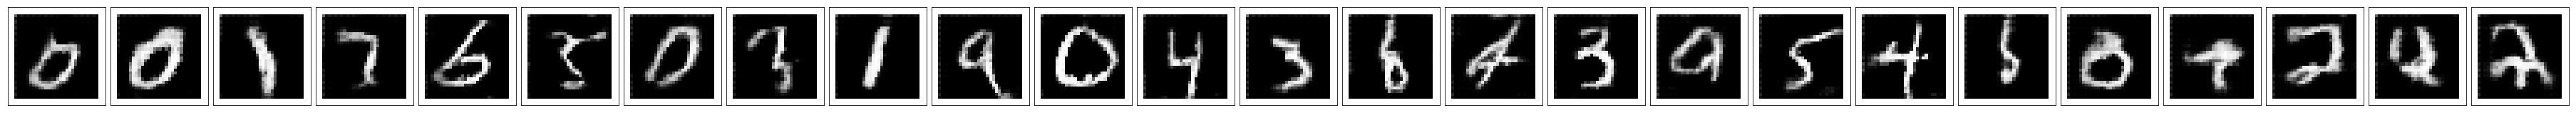

In [154]:
# batch
batch_size = 64

# epoch
epochs = 5

# num of samples
num_sample = 25

shape_noise = 100
get_pic = []
losses = []
steps = 0
tf.reset_default_graph()
# inputs
real_pic, noise_pic = set_input(shape_noise, [-1, 28, 28, 1])
loss_g, loss_d = loss(real_pic, noise_pic, 1)
g_optimizer, d_optimizer = optimize(loss_g, loss_d)

# save
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(num_train // batch_size):
            steps +=1
            batch = data.train.next_batch(batch_size)

            pic_batch = batch[0].reshape((batch_size, shape_img[1],
                                          shape_img[2], shape_img[3]))

            pic_batch = 2 * pic_batch - 1

            # input for the generator
            in_g = np.random.uniform(-1, 1, size=(batch_size, shape_noise))

            # Optimzer
            _ = sess.run(d_optimizer, feed_dict={real_pic: pic_batch, noise_pic: in_g})
            _ = sess.run(g_optimizer, feed_dict={noise_pic: in_g})


#         print("Epoch {}/{}....".format(e + 1, epochs),
#               "Discriminator Loss: {:.4f}....".format(train_loss_d),
#               "Generator Loss: {:.4f}....".format(train_loss_g))

        # save the losses
            if steps % 100 == 0:
                        # loss
                train_loss_d = sess.run(loss_d, feed_dict={real_pic: pic_batch,
                                                       noise_pic: in_g})
            #         train_loss_d_real = sess.run(loss_d1, feed_dict={real_pic: pic_batch,
            #                                                    noise_pic: in_g})
            #         train_loss_d_fake = sess.run(loss_d2, feed_dict={real_pic: pic_batch,
            #                                                    noise_pic: in_g})

                train_loss_g = sess.run(loss_g, feed_dict={real_pic: pic_batch,
                                                       noise_pic: in_g})

                samples = show_generator_output(sess, num_sample, noise_pic, shape_img[-1])
                plot_images(samples)
                get_pic.append(samples)
                print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))
#         losses.append((train_loss_d, train_loss_g))

#         # get the images in differen phases
#         in_sample = np.random.uniform(-1, 1, size=(num_sample, shape_noise))
#         pic_generate = sess.run(generator(noise_pic,  shape_img[-1], share=True),
#                                 feed_dict={noise_pic: in_sample})
#         get_pic.append(pic_generate)
#         # save the checkpoints for NN transfer
        final_expamples = show_generator_output(sess, 100, noise_pic, shape_img[-1])
        saver.save(sess, '/check_NN/para_NN.ckpt')
with open('samples_DCgan.pkl', 'wb') as f:
    pickle.dump(get_pic, f)
with open('samples_DCgan_final.pkl', 'wb') as f:
    pickle.dump(final_expamples, f)

In [175]:
with open('samples_DCgan_final.pkl', 'rb') as f:
    pic_generate = pickle.load(f)
    
def show_pic_g2(epoch, samples):
    
    fig, axes = plt.subplots(figsize = (20, 80), nrows=20, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [176]:
pic_generate[0].shape

(28, 28)

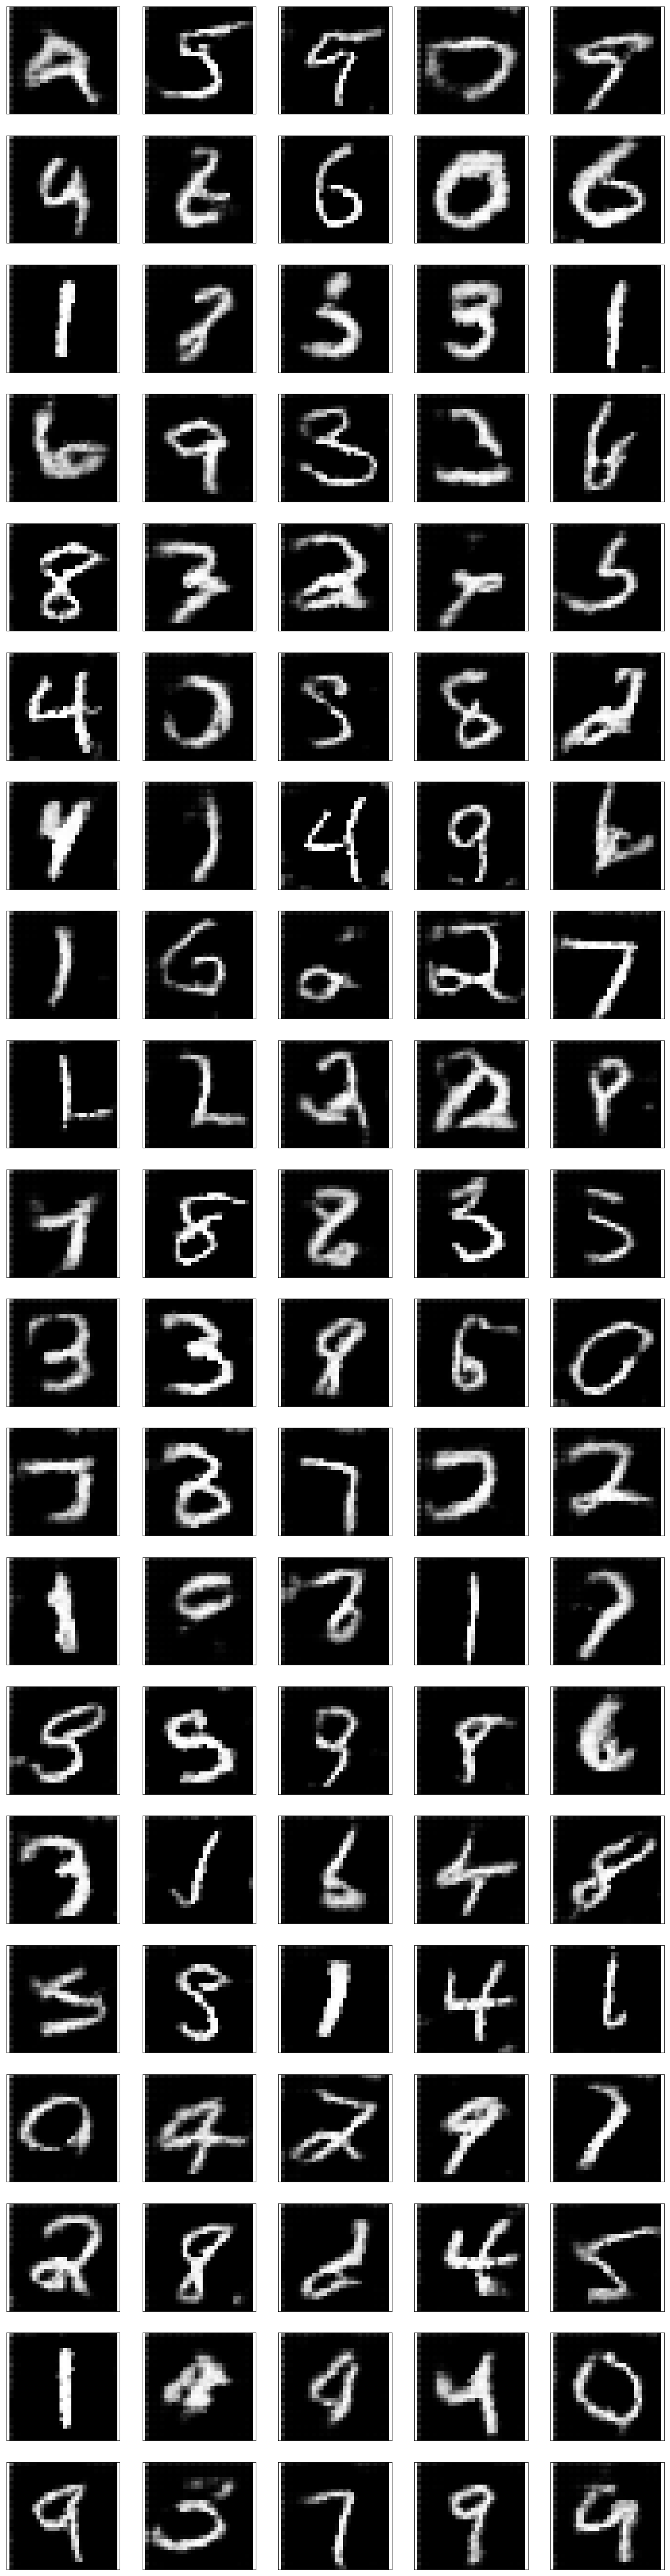

In [177]:
_ = show_pic_g2(1, pic_generate)